In [213]:
'''20.12.2021 CMPE 549 Bioinformatics - Assignment 1 

Implemented By: Maral Dicle Maral - 2020700120

Content: 

Alignment by Needleman-Wunsch Algorithm, Multiseq Alignment by Progressive Alignment Algorithm, UPGMA Tree Implementation
Alignment, Tree Construction, Tree and Sequence Visualization by Bio.Phylo package.

'''

'20.12.2021 CMPE 549 Bioinformatics - Assignment 1 \n\nImplemented By: Maral Dicle Maral - 2020700120\n\nContent: \n\nAlignment by Needleman-Wunsch Algorithm, Multiseq Alignment by Progressive Alignment Algorithm, UPGMA Tree Implementation\nAlignment, Tree Construction, Tree and Sequence Visualization by Bio.Phylo package.\n\n'

In [214]:
import Bio
from Bio import SeqIO
import numpy as np
import pandas as pd
import warnings
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import AlignIO
import matplotlib.pyplot  as plt
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio.Phylo.TreeConstruction import _DistanceMatrix
from Bio import Phylo
from io import StringIO 
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
warnings.filterwarnings("ignore")

In [215]:
'''A small note: I did not convert all characters other than 'A, T, G, C' to '-' before the preprocessing 
because I already desinged the code before the update.'''

"A small note: I did not convert all characters other than 'A, T, G, C' to '-' before the preprocessing \nbecause I already desinged the code before the update."

In [216]:
#Files used for question 1, 2 and 3. 
file_for_q1 = r"./UK Coronavirus Data/Coronavirus Samples/England (NOV032020)/HCOV19-ENGLAND-031120-A.fasta"
file_name_q2 = r"./UK Coronavirus Data/Coronavirus Samples/England (NOV032020)/HCOV19-ENGLAND-031120.fasta" 
aligned_file_for_q3 = [ r"./UK Coronavirus Data/Coronavirus Samples/England (NOV032020)/HCOV19-ENGLAND-031120-A.fasta",r"./UK Coronavirus Data/Coronavirus Samples/England (NOV272020)/HCOV19-ENGLAND-271120-A.fasta",r"./UK Coronavirus Data/Coronavirus Samples/England (DEC082020)/HCOV19-ENGLAND-081220-A.fasta"]

In [217]:
########### QUESTION 1 ###########

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


"Question 1c: For HCOV19-ENGLAND-031120-A.fasta dataset, in my observations most of the nucleotides in sequences are identical. There is a visible deletion mutation in the second or third samle's first 80 nucleotides."

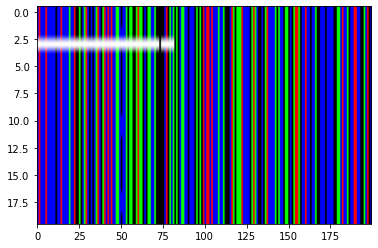

In [218]:
'''
Question 1a, 1b: First 20 samples from November 3rd dataset: HCOV19-ENGLAND-031120-A.fasta, and visualized the first 200 nucleotides of the spike protein gene
Question 1c: What are your observations regarding the resulting visualization? How similar are different nucleotide sequences? Are there any visible mutations
'''
def color_sign(seq_list):

    nucleotide_indices = {'A': [0, 255, 0], 'G': [255, 0, 0], 'T': [0, 0, 255], 'N': [255, 255, 255], 'C': [0, 0, 0]}
    indices = []
    sample_size = len(seq_list)
    seq_size = len(seq_list[0])
    colors = np.zeros(shape=(sample_size, seq_size, 3))

    for sample in range(sample_size):
        for n in range(seq_size):
            colors[sample][n] = nucleotide_indices[seq_list[sample][n]]
    plt.imshow(colors, aspect= 'auto')


#np.set_printoptions(threshold=np.inf, formatter={'str_kind': color_sign})

count = 0
gene_list_toprint = []
gene_list_entropy = []
#file_for_q1 = r"./UK Coronavirus Data/Coronavirus Samples/England (NOV032020)/HCOV19-ENGLAND-031120-A.fasta" #'HCOV19-ENGLAND-031120-A.fasta'
for seq_record in SeqIO.parse(file_for_q1, "fasta"): #HCOV19-ENGLAND-031120-A.fasta
    # print(seq_record.id)
    # 21563 - 25384 spike
    current_seq = seq_record.seq
    spike = current_seq[21563:25384]  # spike gene
    gene_list_entropy.append(spike[0:200])

    if count < 20:
        gene_list_toprint.append(spike[0:200])
    if count > 100:
        break
    count += 1
np_gene = np.array(gene_list_entropy)
np_gene_toprint = np.array(gene_list_toprint)


color_sign(gene_list_toprint)


'''Question 1c: For HCOV19-ENGLAND-031120-A.fasta dataset, in my observations most of the nucleotides in sequences are identical. There is a visible deletion mutation in the second or third samle's first 80 nucleotides.'''

# test[:,0] column
# test[1,:] line



In [219]:
'''Question 1d: The entropy score for all 100 samples from November 3rd is computed.'''


def compute_entropy(data):
    entropy = 0
    a = np.count_nonzero(data == 'A', axis=0)
    g = np.count_nonzero(data == 'G', axis=0)
    c = np.count_nonzero(data == 'C', axis=0)
    t = np.count_nonzero(data == 'T', axis=0)
    n = np.count_nonzero(data == 'N', axis=0)
    n += np.count_nonzero(data == 'K', axis=0)
    nucleotides = [a, g, c, t, n]
    total = a + g + t + c + n

    for nucleotide in nucleotides:
        ratio = nucleotide / total
        # if not ratio == 0:

        temp_entropy = (ratio * np.log(ratio))
        temp_entropy = np.nan_to_num(temp_entropy)
        # print(temp_entropy)
        entropy -= temp_entropy

    return entropy


entropy = compute_entropy(np_gene)
#print('Question 1d: Computed an entropy score for all 100 samples from November 3rd:')
#print('')
print('Question 1d: Entropy results for 100 samples of spike gene for all 100 samples from November 3rd:', np.sum(entropy))

Question 1d: Entropy results for 100 samples of spike gene for all 100 samples from November 3rd: 5.494425698654303


In [220]:
########### QUESTION 2 ###########

In [221]:
'''Question 2a: For the first 5 samples in the data set, nucleotides between 21600: 21799 for each patient was extracted.'''
gene_list_toalign = []
count= 1
#file_name_q2 = r"./UK Coronavirus Data/Coronavirus Samples/England (NOV032020)/HCOV19-ENGLAND-031120.fasta" #"HCOV19-ENGLAND-031120.fasta"
for seq_record in SeqIO.parse(file_name_q2, "fasta"):

    current_seq = seq_record.seq
    interested_seq = current_seq[21600:21800]#[21599:21799]
    gene_list_toalign.append(interested_seq)
    if count >= 5:
        break
    count+= 1
np_gene_list_toalign = np.array(gene_list_toalign)
#print('Question 2a: For the first 5 samples in the data set, extracted the nucleotides between 21600: 21799 for each patient.')
#print('')
print('Question 2a: For the first 5 samples in the data set, nucleotides between 21600: 21799, I end up with a matrix of:')
print(np_gene_list_toalign.shape)


Question 2a: For the first 5 samples in the data set, nucleotides between 21600: 21799, I end up with a matrix of:
(5, 200)


In [222]:
'''
Question 2b: The Needleman-Wunsch global sequence alignment algorithm was implemented to compute pairwise alignment score between any two nucleotide sequences. For scoring, use 5 for a match, -4 for a mismatch or an indel.
'''

def needleman_wunsch(seq1, seq2):
    up = "U"
    right = "R"
    left = "L"
    up_left = "D"

    # Creates a matix of 0's to give the pandas df.
    df = []
    traceback = []
    # columns are seq2, raws are seq1 in this nested list:
    for i in range(0, len(seq2)):
        listofzeros = [0] * len(seq1)
        df.append(listofzeros)
        listofempty = ['-'] * len(seq1)
        traceback.append(listofempty)
    # df = pd.DataFrame(data_list,index=seq1,columns=seq2)

    # Needleman algorithm
    
    match_score = 5
    mismatch_penalty = -4
    indel_penalty = -4


    for row in range(0, len(seq1)):
        for column in range(0, len(seq2)):
            if row == 0 and column == 0:
                continue
            # first, filled the 0 rows and 0 columns.
            elif row == 0:
                previous = df[row][column - 1]
                new_score = previous + indel_penalty
                df[row][column] = new_score
                arrow = left
            elif column == 0:
                previous = df[row - 1][column]
                new_score = previous + indel_penalty
                df[row][column] = new_score
                arrow = up
            else:
                deletion = df[row - 1][column] + indel_penalty
                insertion = df[row][column - 1] + indel_penalty

                if seq1[row] == seq2[column]: # If it is a match 
                    match = df[row - 1][column - 1] + match_score
                else:  # If it is a deletion, mismatch or delete
                    match = df[row - 1][column - 1] + mismatch_penalty

                score = max([deletion, insertion, match])
                df[row][column] = score

                if score == insertion:
                    arrow = left
                elif score == deletion:
                    arrow = up
                elif score == match:
                    arrow = up_left

            traceback[row][column] = (arrow)
    # df_trace = pd.DataFrame(traceback, index=seq1, columns=seq2)
    # print(df_trace)

    # df_pd = pd.DataFrame(df,index=seq1,columns=seq2)
    # print(df_pd)
    return df, traceback

In [223]:
'''Backtrace algorithm for needleman-wunsch.'''
def backtrace(seq1, seq2, traceback, df):
    
    seq1_aligned = []
    seq2_aligned = []
    row = len(seq1) - 1
    column = len(seq2) - 1
    current_cell = traceback[row][column]
    match_score = 0

    up = "U"
    right = "R"
    left = "L"
    diagonal = "D"

    while current_cell != '-':
        current_cell = traceback[row][column]

        if current_cell == up:
            seq2_aligned.append('-')
            seq1_aligned.append(seq1[row])
            row -= 1
            match_score -= 4

        elif current_cell == left:
            seq1_aligned.append('-')
            seq2_aligned.append(seq2[column])
            column -= 1
            match_score -= 4
        elif current_cell == diagonal:
            seq1_aligned.append(seq1[row])
            seq2_aligned.append(seq2[column])
            if seq1[row] == seq2[column]:
                match_score += 5
            else:
                match_score -= 4
            row -= 1
            column -= 1
        elif current_cell == '-':
            break

    seq1_aligned.reverse()
    seq1_aligned = "".join(seq1_aligned)
    seq2_aligned.reverse()
    seq2_aligned = "".join(seq2_aligned)

    return seq1_aligned, seq2_aligned, match_score


Question 2b, c: The pairwise distance matrix using my needleman-wunch function for the first 5 samples in HCOV19-ENGLAND-031120-fasta.
The pairwise distance matrix using my needleman-wunch function:

SCORE MATRIX:
      0     1     2     3     4
0  1000     -     -     -     -
1   714  1000     -     -     -
2   792   922  1000     -     -
3   714  1000   922  1000     -
4   792   922  1000   922  1000

DISTANCE MATRIX:
     0   1   2   3  4
0    0   -   -   -  -
1  286   0   -   -  -
2  208  78   0   -  -
3  286   0  78   0  -
4  208  78   0  78  0

Question 2d: The guide tree of the first 5 samples in HCOV19-ENGLAND-031120-fasta sample using the neighbor joining algorithm implemented in Phylo module of Biopython package.



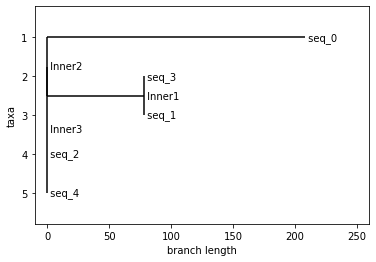

In [224]:
'''
Question 2c: The pairwise distance matrix using my needleman-wunch function.
Question 2d: Created a guide tree using the neighbor joining algorithm implemented in Phylo module of Biopython package.
'''

def compute_score_matrix(gene_list_toalign):
    score_matrix = []
    distance_matrix = []
    distance_for_phylo = []
    for i in range(len(gene_list_toalign)):
        listofempty = ['-'] * len(gene_list_toalign)
        listofempty2 = ['-'] * len(gene_list_toalign)
        listofempty3 = ['-'] * len(gene_list_toalign)
        score_matrix.append(listofempty)
        distance_matrix.append(listofempty2)
        distance_for_phylo.append(listofempty3)

    s_list = []
    max_score = 0
    for s in range(len(gene_list_toalign)):
        for k in range(len(gene_list_toalign)):
            if [k, s] in s_list:
                continue
                
            s_list.append([s, k])

            seq1 = [label for label in '*' + gene_list_toalign[s]]
            seq2 = [label for label in '*' + gene_list_toalign[k]]

            df, traceback = needleman_wunsch(seq1, seq2)
            seq1_aligned, seq2_aligned, match_score = backtrace(seq1, seq2, traceback, df)
            
            if match_score >= max_score:
                max_score = match_score 


            score_matrix[k][s] = match_score

            distance_matrix[k][s] = (max_score - match_score)
            distance_matrix[s][k] = (max_score - match_score)
            
            distance_for_phylo[k][s] = (max_score - match_score)
    print('The pairwise distance matrix using my needleman-wunch function:')
    print('')
    print('SCORE MATRIX:')
    print(pd.DataFrame(score_matrix))
    print('')
    print('DISTANCE MATRIX:')
    print(pd.DataFrame(distance_for_phylo))


    count = 0
    distance_matrix_for_phylo = []
    distance_for_phylo_names = []
    for row in distance_for_phylo:
        distance_for_phylo_names.append('seq_' + str(count))
        count += 1
        temp = []
        for r in row:
            if r != '-':
                temp.append(r)
        distance_matrix_for_phylo.append(temp)
    return score_matrix, distance_matrix, distance_matrix_for_phylo, distance_for_phylo_names
print('Question 2b, c: The pairwise distance matrix using my needleman-wunch function for the first 5 samples in HCOV19-ENGLAND-031120-fasta.')
q2, distance_q2, distance_for_nj, distance_for_nj_names = compute_score_matrix(gene_list_toalign)


# Computes the phylo tree with neighbor joining algorithm for the first 5 samples in HCOV19-ENGLAND-031120-fasta sample

phylo_matrix_nj = _DistanceMatrix(distance_for_nj_names, distance_for_nj)
constructor = DistanceTreeConstructor()
nj_tree = constructor.nj(phylo_matrix_nj)
allclades = list(nj_tree.find_clades(order="level"))

lookup = {}
for i, elem in enumerate(allclades):
    lookup[elem] = i
tree_children = []
for parent in nj_tree.find_clades(terminal=False, order="level"):
    for child in parent.clades:
        tree_children.append(child)

tree_children.reverse()
print('') 
print('Question 2d: The guide tree of the first 5 samples in HCOV19-ENGLAND-031120-fasta sample using the neighbor joining algorithm implemented in Phylo module of Biopython package.')
print('')
Phylo.draw(nj_tree)

# upgma_tree = constructor.upgma(dm)
# print(upgma_tree)

In [225]:
'''Question 2e: The progressive alignment of your 5 samples according to the Needleman-Wunsch algorithm, producing the final multiple sequence alignment. '''

def progressive_alignment(seq1, seq2):
    up = "U"
    right = "R"
    left = "L"
    up_left = "D"

    # Creates a matix of 0's to give to the df.
    df = []
    traceback = []
    new_profile = []
    # columns are seq2, rows are seq1 in this nested list:
    for i in range(0, len(seq2)):
        listofzeros = [0] * len(seq1)
        df.append(listofzeros)
        listofempty = ['-'] * len(seq1)
        traceback.append(listofempty)


    # Needleman algorithm
    match_score =5
    mismatch_penalty = -4
    indel_penalty = -4

    for row in range(0, len(seq1)):
        for column in range(0, len(seq2)):
            if row == 0 and column == 0:
                continue
            elif row == 0:
                previous = df[row][column - 1]
                new_score = previous + indel_penalty
                df[row][column] = new_score
                winner_arrow = left
            elif column == 0:
                previous = df[row - 1][column]
                new_score = previous + indel_penalty
                df[row][column] = new_score
                winner_arrow = up
            else:
                sub_scores = {}


                for k1, i1 in seq1[row].items():
                    for k2, i2 in seq2[column].items():
                        if i1 == 0 and i2 == 0:
                            continue
                        weight = (i1 + i2) / 2


                        weighted_del = indel_penalty * weight
                        weighted_insert = indel_penalty * weight

                        deletion = df[row - 1][column] + indel_penalty
                        insertion = df[row][column - 1] + indel_penalty

                        if k1 == k2:  # If it is a match
                            weighted_match = match_score * weight
                            match = df[row - 1][column - 1] + weighted_match

                        else:  # If it is a deletion, mismatch or delete
                            weighted_match = mismatch_penalty * weight
                            match = df[row - 1][column - 1] + mismatch_penalty

                        sub_score = max([deletion, insertion, match])

                        if sub_score == insertion:
                            arrow = left
                        elif sub_score == deletion:
                            arrow = up
                        elif sub_score == match:
                            arrow = up_left

                        sub_scores[sub_score] = arrow

                winner_score = max(sub_scores.keys())
                df[row][column] = winner_score
                winner_arrow = sub_scores[winner_score]

                

            traceback[row][column] = (winner_arrow)
    # df_trace = pd.DataFrame(traceback, index=seq1, columns=seq2)
    # print(df_trace)

    # df_pd = pd.DataFrame(df,index=seq1,columns=seq2)
    # print(df_pd)
    return df, traceback

In [226]:
def backtrace_profile(seq1, seq2, traceback):

    seq1_aligned = []
    seq2_aligned = []

    row = len(seq1) - 1
    column = len(seq2) - 1
    current_cell = traceback[row][column]

    up = "U"
    left = "L"
    diagonal = "D"

    while current_cell != '-':
        current_cell = traceback[row][column]

        if current_cell == up:
            seq2_aligned.append({'A': 0, 'G': 0, 'C': 0, 'T': 0, '-':1, '*':0})
            seq1_aligned.append(seq1[row])
            row -= 1

        elif current_cell == left:
            seq1_aligned.append({'A': 0, 'G': 0, 'C': 0, 'T': 0, '-':1, '*':0})
            seq2_aligned.append(seq2[column])
            column -= 1
        elif current_cell == diagonal:
            seq1_aligned.append(seq1[row])
            seq2_aligned.append(seq2[column])
            row -= 1
            column -= 1

    seq1_aligned.reverse()
    seq2_aligned.reverse()
    nucleotide_list = ['A','G','C','T','-','*']
    
    # Creates a new profile from the current ones.
    new_profile = []
    for i in range(len(seq1_aligned)):
        if i==0:
            new_profile.append({'A': 0, 'G': 0, 'C': 0, 'T': 0, '-':0, '*':1})
        if seq1_aligned[i]['-'] ==1:
            continue
        new_profile_nucleotides = {'A': 0, 'G': 0, 'C': 0, 'T': 0, '-':0, '*':0}
        for n in nucleotide_list:
            new_profile_nucleotides[n]= (seq1_aligned[i][n] + seq2_aligned[i][n])/2
        new_profile.append(new_profile_nucleotides)


    return seq1_aligned, seq2_aligned, new_profile


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'Question 2e, f: MSA results of my progressive alignment algorithm for first five samples of HCOV19-ENGLAND-031120.fasta file shows a perfect match. '

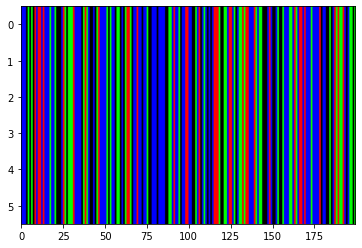

In [199]:
'''Question 2f: Visualize the results of your alignment algorithm similarly to the first question. Note: You
can use matplotlib.pyplot.imshow for plotting or another function of your choice.'''

def compute_score_matrix_for_profiles(tree, gene_list_toalign):
    seq_list_msa = {}
    gene_list_msa= []
    # Creates profiles for each sequence for the progressive algorithm
    seq_list_msa =  {}
    for i in range(len(gene_list_toalign)):
        seq_name = 'seq_' + str(i)
        profile = []
        gene_list_msa.append( '*' + gene_list_toalign[i])
        for nucleotide in gene_list_msa[i]:
            nucleotide_list = {'A': 0, 'G': 0, 'C': 0, 'T': 0, '-':0, '*':0}
            nucleotide_list[nucleotide] = 1
            profile.append(nucleotide_list)
        seq_list_msa[seq_name]= profile

    aligned_list = []
    df, traceback = progressive_alignment(seq_list_msa[tree[0].name], seq_list_msa[tree[1].name])
    seq1_aligned, seq2_aligned, new_profile = backtrace_profile(seq_list_msa[tree[0].name], seq_list_msa[tree[0].name], traceback)
    aligned_list.append(seq1_aligned)

    for c in range(len(tree)):
        if 'Inner' not in tree[c].name:
            df, traceback = progressive_alignment(seq_list_msa[tree[c].name], new_profile)
            seq1_aligned, seq2_aligned, new_profile = backtrace_profile(seq_list_msa[tree[0].name], new_profile, traceback)
            aligned_list.append(seq1_aligned)

    aligned_list_string= []
    for s in aligned_list:
        sequence = ''
        for n in s:
            if n['A']==1:
                sequence+= 'A'
            elif n['C']==1:
                sequence+= 'C'
            elif n['G']==1:
                sequence+= 'G'
            elif n['T']==1:
                sequence+= 'T'
            elif n['-']==1:
                sequence+= '-'
        aligned_list_string.append(sequence)
    color_sign(aligned_list_string)


compute_score_matrix_for_profiles(tree_children, gene_list_toalign)

'''Question 2e, f: MSA results of my progressive alignment algorithm for first five samples of HCOV19-ENGLAND-031120.fasta file shows a perfect match. '''

In [200]:
########### QUESTION 3 ###########

In [201]:
'''Retrieves the spike gene sequence from the given samples, returns the list of samples' sequences '''
def seq_io_spike(filename, sample_size):
    if sample_size == -1:
        sample_size = float('inf') 
    gene_list_toprint = []
    gene_list= []
    gene_list_names= []
    #gene_list_phylo = []
    count = 0
    for seq_record in SeqIO.parse(filename, "fasta"):
        #print(seq_record.id)
        #21563 - 25384 spike
        current_seq = seq_record.seq
        spike = current_seq[21563:25384] #spike gene
        #gene_list_phylo.append(SeqRecord(spike))
        gene_list.append(spike)
        gene_list_names.append(seq_record.id)
        if count >=sample_size-1:
            break
        count+=1
    np_gene = np.array(gene_list)

    return(gene_list, gene_list_names)



In [202]:
'''Question 3a: The score and distance matrix for 12 samples from the first 4 aligned November 3, November 27, and December 8 data:'''
print('Question 3a: The score and distance matrix for 12 samples from the first 4 aligned November 3, November 27, and December 8 data:')
print('')
print('')

#aligned_file_for_q3 = [ r"./UK Coronavirus Data/Coronavirus Samples/England (NOV032020)/HCOV19-ENGLAND-031120-A.fasta",r"./UK Coronavirus Data/Coronavirus Samples/England (NOV272020)/HCOV19-ENGLAND-271120-A.fasta",r"./UK Coronavirus Data/Coronavirus Samples/England (DEC082020)/HCOV19-ENGLAND-081220-A.fasta"]
all_samples = []
all_samples_names = []
for file in aligned_file_for_q3:
    samples, names = seq_io_spike(file,4)
    all_samples.extend(samples)
    all_samples_names.extend(names)


score_matrix_for_UPGMA, distance_matrix, distance_for_phylo, distance_for_phylo_names = compute_score_matrix(all_samples)

Question 3a: The score and distance matrix for 12 samples from the first 4 aligned November 3, November 27, and December 8 data:


The pairwise distance matrix using my needleman-wunch function:

SCORE MATRIX:
       0      1      2      3      4      5      6      7      8      9   \
0   19105      -      -      -      -      -      -      -      -      -   
1   14623  19105      -      -      -      -      -      -      -      -   
2   14596  19060  19105      -      -      -      -      -      -      -   
3   15847  16405  16387  19105      -      -      -      -      -      -   
4   15104  15361  15334  16585  19105      -      -      -      -      -   
5   16585  17125  17098  18349  17323  19105      -      -      -      -   
6   16576  17116  17107  18349  17314  19078  19105      -      -      -   
7   16567  17125  17080  18331  17305  19069  19060  19105      -      -   
8   15167  15262  15235  16486  19006  17224  17215  17242  19105      -   
9   14416  15118  15127  16171

In [203]:
'''Finds the minimum value in the distance tree, return its value and index.'''
def find_min(df, names): 
    min_value= 100000000
    min_index=[]
    
    for name in names:
        for name2 in names:
            if name == name2:
                continue
            if df[name][name2]< min_value:
                min_value = df[name][name2]
                min_index = [name, name2]

    return min_value, min_index
    

In [204]:
'''UPGMA tree implementation, returns the tree in the newick form.'''
def UPGMA(distance_matrix, names, real_names):
    
    names_dict= {}
    for n in range(len(names)):
        names_dict[names[n]]=real_names[n]
        
    df = pd.DataFrame(distance_matrix, index=names, columns=names)
    total_val = 0 
    while len(df.columns) > 1:
        min_value, min_index = find_min(df, names)
        old_val= total_val
        total_val= min_value/2
        branch_val= total_val - old_val
        idx0 = min_index[0]
        idx1 = min_index[1]
        clade = '(' + names_dict[idx0] + ':'+ str(branch_val) + ',' + names_dict[idx1] + ':'+ str(branch_val) + ')'

        
        new_names = []
        for name in names:
            if not name == idx0:
                if not name == idx1:
                    new_names.append(name)
        new_names.append(clade)
        names_dict[clade]=clade
    
        new_dist_list = []
        for name in names:
            if name == idx0 or name == idx1:
                continue
            new_distance_to_seq = (df[name][idx0] + df[name][idx1])/2
            new_dist_list.append(new_distance_to_seq)
        df = df.drop(idx0, axis=1)
        df = df.drop(idx0, axis=0)
        df = df.drop(idx1, axis=1)
        df = df.drop(idx1, axis=0)
    
        df[clade]= new_dist_list
        new_dist_list.append(0)
        df.loc[clade] = new_dist_list
        names = new_names
    return names[0] + ';'


Question 3b: Implemented the upgma algorithm and formed the upgma tree in newick format:

(hCoV-19/England/QEUH-B2C276/2020|EPI_ISL_680074|2020-11-03:327.44140625,(hCoV-19/England/CAMC-C2CE35/2020|EPI_ISL_733688|2020-12-08:333.984375,((hCoV-19/England/LOND-125269F/2020|EPI_ISL_842663|2020-12-08:150.75,(hCoV-19/England/LIVE-DC0CA1/2020|EPI_ISL_702779|2020-11-03:1.125,hCoV-19/England/LIVE-DC0EF6/2020|EPI_ISL_702792|2020-11-03:1.125):150.75):376.6640625,((hCoV-19/England/QEUH-BCB8A4/2020|EPI_ISL_703872|2020-11-27:27.0,hCoV-19/England/SHEF-10CF40E/2020|EPI_ISL_702633|2020-12-08:27.0):716.34375,(hCoV-19/England/LOND-DA45E/2020|EPI_ISL_724629|2020-11-03:183.375,(hCoV-19/England/SHEF-10D4372/2020|EPI_ISL_727967|2020-11-27:5.625,(hCoV-19/England/CAMC-C2C970/2020|EPI_ISL_733856|2020-12-08:2.25,(hCoV-19/England/NOTT-11F97B/2020|EPI_ISL_725591|2020-11-27:13.5,hCoV-19/England/PORT-2F60DE/2020|EPI_ISL_741738|2020-11-27:13.5):2.25):5.625):183.375):716.34375):376.6640625):333.984375):327.44140625);



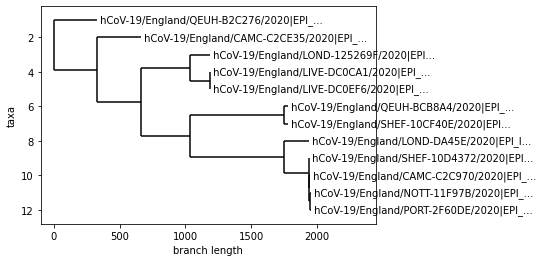

In [206]:
'''Question 3b: The newick representation of the upgma tree created by my own upgma implementation:'''
'''Question 3c: Visualization of my upgma tree with the phylo module:'''
print('Question 3b: Implemented the upgma algorithm and formed the upgma tree in newick format:')
print('')
my_upgma_tree = UPGMA(distance_matrix, distance_for_phylo_names, all_samples_names)
print(my_upgma_tree)
print('')
print('')
print('Question 3c: Visualization of my upgma tree with the phylo module:')
tree_handle = StringIO(my_upgma_tree)
my_tree = Phylo.read(tree_handle, "newick")
Phylo.draw(my_tree)


Question 3d: The UPGMA algorithm provided in the Phylo module is used to construct the tree, and visualized it:

Although the tree of my own implementation and phylo module are not identical, the closest pairs in the trees are similar to each other as well as the branching. My tree somehow looks like upside down version of the phylo tree. 



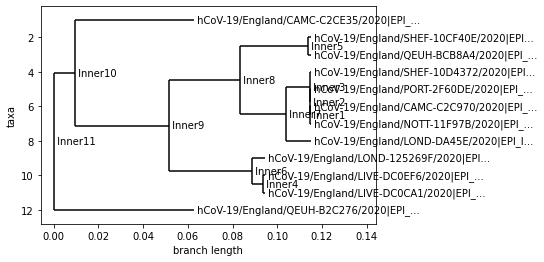

In [210]:
'''Question 3d: The UPGMA algorithm provided in the Phylo module is used to construct the tree, and visualized it:'''
'''Although the tree of my own implementation and phylo module are not identical, the closest pairs in the trees are similar to each other as well as the branching. My tree somehow looks like upside down version of the phylo tree. '''
print('Question 3d: The UPGMA algorithm provided in the Phylo module is used to construct the tree, and visualized it:')
print('')
print('Although the tree of my own implementation and phylo module are not identical, the closest pairs in the trees are similar to each other as well as the branching. My tree somehow looks like upside down version of the phylo tree. ')
print('')
#aligned_file_for_q3 = [ r"./UK Coronavirus Data/Coronavirus Samples/England (NOV032020)/HCOV19-ENGLAND-031120-A.fasta",r"./UK Coronavirus Data/Coronavirus Samples/England (NOV272020)/HCOV19-ENGLAND-271120-A.fasta",r"./UK Coronavirus Data/Coronavirus Samples/England (DEC082020)/HCOV19-ENGLAND-081220-A.fasta"]
seq_record = []

for file in aligned_file_for_q3:
    count = 0
    for rec in SeqIO.parse(file,format='fasta'):
        seq_record.append(rec[21563:25384])
        count+=1
        if count >=4:
            break
small_aligned_data = MultipleSeqAlignment(seq_record)
small_calculator = DistanceCalculator('identity')
dm_for_small_phylo = small_calculator.get_distance(small_aligned_data)
small_constructor = DistanceTreeConstructor(small_calculator, 'upgma')
small_tree = small_constructor.build_tree(small_aligned_data)
Phylo.draw(small_tree)


Question 3e: The phylogenetic tree for all the samples from the first 4 aligned November 3, November 27, and December 8 data:



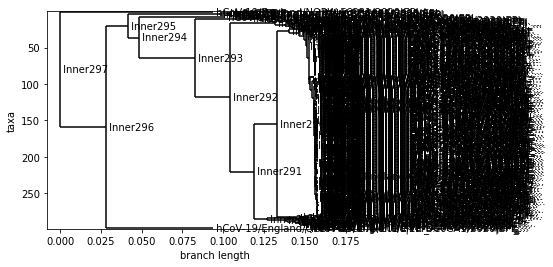

In [227]:
'''Question 3e: The phylogenetic tree for all the samples from the first 4 aligned November 3, November 27, and December 8 data:'''

print('Question 3e: The phylogenetic tree for all the samples from the first 4 aligned November 3, November 27, and December 8 data:')
print('')
seq_record_for_all= []

for file in aligned_file_for_q3:
    count = 0
    for rec in SeqIO.parse(file,format='fasta'):
        seq_record_for_all.append(rec[21563:25384])

all_aligned_data = MultipleSeqAlignment(seq_record_for_all)

calculator = DistanceCalculator('identity')
dm_for_phylo = calculator.get_distance(all_aligned_data)
constructor = DistanceTreeConstructor(calculator, 'upgma')
all_tree = constructor.build_tree(all_aligned_data)
Phylo.draw(all_tree)

